#**Trabajo práctico N°** | Ejercicio 1.  
| Aprendizaje Automático II.  
| Tec. Universitaria en Inteligencia Artificial  
| Facultad de Cs. Exactas, Ingeniería y Agrimensura.  

**Integrantes**
- López Ceratto, Julieta: L-3311/1
- Rodríguez Griñó, Tomás: R-4643/4
- Slepoy, David: S-5782/7

**[ES]** El objetivo de este trabajo es aplicar redes convolucionales y recurrentes para predecir el dígito del 0 al 9 que se pronuncia en un audio dado. Para ello, se realiza un análisis descriptivo del dataset, entrenamiento de ambos modelos, evaluación y comparación de los mismos.

**[EN]** The goal of this work is to apply convolutional and recurrent networks in order to predict te number from 0 to 9 pronounced in a audiofile. For this, descriptive análisis, both model training and the evaluation and comparative of them are made.

## Preparación del entorno.

In [1]:
!pip install -q tfds-nightly tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 22.1 MB/s eta 0:00:00


### Importamos las librerias

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import shutil
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from IPython import display
from IPython.display import Audio, HTML, display
import IPython.display as ipd
import tensorflow_datasets as tfds
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Buscamos GPU fisico

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Revisamos entre todos los datasets de TFDS para detectar el dataset de audios y lo guardamos

In [4]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'ai2dcaption',
 'aloha_mobile',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asimov_dilemmas_auto_val',
 'asimov_dilemmas_scifi_train',
 'asimov_dilemmas_scifi_val',
 'asimov_injury_val',
 'asimov_multimodal_auto_val',
 'asimov_multimodal_manual_val',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 '

In [5]:
#Guardamos el dataset con sus metadatos
ds, info = tfds.load('spoken_digit', split='train', with_info=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/spoken_digit/incomplete.O1XOOP_1.0.9/spoken_digit-train.tfrecord*...:   0%…

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


## Funciones a utilizar.

Definimos las funciones que se utilizarán a lo largo del ejercicio.

In [6]:
def extract_locutor(filename:str)->str:
  '''
  Extrae el nombre del locutor dado el nombre de un archivo.
  ---------------------------------------------------------
  Parámetros:
   - filename: nombre del archivo.
  --------------------------------------------------------
  Retorna:
   - locutor: nombre del locutor. / unknown si no puede extraerlo.
  '''
  parts = filename.split(b'_')
  if len(parts) >= 3:
    locutor = parts[-2].decode('utf-8')
    return locutor
  return 'unknown'

In [7]:
def filter_by_length(example)-> bool:
  '''
  Detecta si un audio es outlier o no y devuelve True o False
  según corresponda

  '''
  audio_length = tf.shape(example["audio"])[0]
  return tf.logical_and(audio_length >= lower_bound, audio_length <= upper_bound)

In [8]:
def get_spectrogram(waveform):
  '''
  Grafica un espectoframa a partir de un waveform.
  '''
  spectrogram = tf.signal.stft(waveform, frame_length=1024, frame_step=256)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [9]:
def plot_spectrogram_padded(spectrogram, ax, total_samples=4000, frame_step=256):
  """
  Grafica un espectrograma con padding horizontal para asegurar una longitud fija en el eje del tiempo.

  Esta función recibe un espectrograma (en forma de matriz de magnitudes), lo transforma a escala logarítmica
  para mejorar su visualización, y lo grafica utilizando un mapa de colores tipo 'inferno'. Si el espectrograma
  es más corto que `total_samples` (en términos del eje del tiempo), se le aplica padding con valores mínimos
  (negro) para completar hasta la longitud deseada.

  Parámetros:
  -----------
  spectrogram : np.ndarray
      Matriz del espectrograma, de forma (frecuencia, tiempo) o (frecuencia, tiempo, 1).
      Puede contener un canal adicional que será eliminado.

  ax : matplotlib.axes.Axes
      Objeto de ejes de Matplotlib sobre el cual se dibujará el espectrograma.

  total_samples : int, opcional (default=4000)
      Cantidad total de muestras de audio que se desea representar en el eje X. Sirve como referencia para el padding.

  frame_step : int, opcional (default=256)
      Paso entre ventanas de la STFT (Short-Time Fourier Transform), usado para calcular la escala del eje X.

  Devuelve:
  ---------
  None. El gráfico es renderizado directamente en el eje proporcionado.
  """
  # Si el espectrograma tiene un canal extra, lo elimina
  if len(spectrogram.shape) > 2:
      spectrogram = np.squeeze(spectrogram, axis=-1)

  # Conversión a escala logarítmica para mejor visualización
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height, width = log_spec.shape

  # Padding si el espectrograma es más corto que el total deseado
  target_width = int(np.ceil(total_samples / frame_step))
  if target_width > width:
      pad_cols = target_width - width
      log_spec = np.pad(log_spec, ((0, 0), (0, pad_cols)), constant_values=np.min(log_spec))

  # Ejes del gráfico
  X = np.arange(log_spec.shape[1]) * frame_step
  Y = np.arange(log_spec.shape[0])

  # Grafica el espectrograma
  ax.pcolormesh(X, Y, log_spec, shading='auto', cmap='inferno')
  ax.set_xlim([0, total_samples])
  ax.set_xlabel("Samples")
  ax.set_ylabel("Frequency bins")

In [10]:
# Función para generar y guardar espectrogramas
def save_spectrogram(audio, filename:str, spectrogram_dir="spectrogram_directory")-> None:
  '''
  Graba una carpeta 'spectograms' donde cada espectograma se corresponde con un audio.
  El nombre del espectograma se condice con el nombre del audio.
  También hace en procesamiento el escalado de cada espectograma a [0,1].
  ---------------------------------------------------------------------------
  Parámetros:
   - audio: audio para generar el espectograma.
   - filename: nombre del archivo de audio.
   - spectrogram_dir: directorio donde se guardarán los espectrogramas.

  '''
  #Nos asegurmosa que el directorio existe
  pathlib.Path(spectrogram_dir).mkdir(parents=True, exist_ok=True)

  # Convierte el tensor de audio a un array de numpy
  if isinstance(audio, tf.Tensor):
      audio = audio.numpy()

  audio = tf.cast(audio, tf.float32)

  # Calcula la Transformada de Fourier de Tiempo Corto (STFT)
  spectrogram = tf.signal.stft(
      audio, frame_length=255, frame_step=128)

  # Toma los valores absolutos y convierte a un espectro de potencia
  spectrogram = tf.abs(spectrogram)+ 1e-6

   # Convierte a escala logarítmica (dB)
  spectrogram = tf.math.log(spectrogram)

  # --- Normalización a [0, 1] ---
  spectrogram_min = tf.reduce_min(spectrogram)
  spectrogram_max = tf.reduce_max(spectrogram)
  spectrogram = (spectrogram - spectrogram_min) / (spectrogram_max - spectrogram_min + 1e-10)


  # Decodifica el tensor del nombre del archivo a una cadena
  filename_str = filename.numpy().decode('utf-8')

  # Extraer clase (dígito) desde el nombre
  label = filename_str.split('_')[0]


  spectrogram_path = os.path.join(spectrogram_dir, label)
  pathlib.Path(spectrogram_path).mkdir(parents=True, exist_ok=True)
  # Crea el nombre del archivo para la imagen del espectrograma
  spectrogram_filename = os.path.join(spectrogram_path, os.path.basename(filename_str).replace('.wav', '.png'))


  # Guarda el espectrograma como una imagen
  plt.figure(figsize=(10, 4))
  ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
  ax.set_axis_off()
  plt.gcf().add_axes(ax)
  ax.imshow(tf.transpose(spectrogram), aspect='auto', origin='lower', cmap='viridis')
  plt.savefig(spectrogram_filename, bbox_inches='tight', pad_inches=0)
  plt.close()

  print(f"Espectrograma guardado para {os.path.basename(filename_str)} en {spectrogram_filename}")


In [11]:
def get_ordered_file_paths(directory):
  '''
  Obtiene los file_paths ordenados alfabeticamente dado un directorio.
  -------------------------------------------------------------------
  Parámetros:
    directory: str. Directorio de donde obtener los filepaths ordenados.
  -------------------------------------------------------------------
  Retorna:
    file_paths: list. Lista de filepaths ordenados.

  '''
  directory = pathlib.Path(directory)
  class_names = sorted([item.name for item in directory.iterdir() if item.is_dir()])
  file_paths = []

  for class_name in class_names:
      class_dir = directory / class_name
      class_files = sorted(class_dir.glob("*"))
      file_paths.extend(class_files)
  return file_paths

In [12]:
def preprocess(x, y, img_height = 64, img_width = 64):
  '''
  Prerppocesa una imagen, dado una imagen y su label, y devuelve
  la imagen procesada con dicho label. Los procesamientos aplicados (en orden)
  son:
   - resize a 64x64.
   - Conversión a escala de grises.
   - Normalización a [0,1].
  -------------------------------------------------------------------------
  Parámetros:
   - x: imagen.
   - y: label.
  -------------------------------------------------------------------------
  Retorna:
   - x: imágen procesada.
   - y: label.
  '''

    # Convierte RGB a grayscale si es necesario
  x = tf.image.resize(x, (img_height, img_width))
  x = tf.image.rgb_to_grayscale(x)
  x = tf.squeeze(x, axis=-1)

  # Normalizar a [0,1]
  x = tf.cast(x, tf.float32) / 255.0
  return x, y

## División de dataset

In [13]:
# Dividir el dataset en train 70%, val 15%, test 15%
train_ds = ds.take(int(0.7 * info.splits['train'].num_examples))
val_ds = ds.skip(int(0.7 * info.splits['train'].num_examples)).take(int(0.15 * info.splits['train'].num_examples))
test_ds = ds.skip(int(0.85 * info.splits['train'].num_examples))

Cantidad de muestras de entrenamiento

In [14]:
tfds.as_dataframe(train_ds.take(4), info)
info.splits['train'].num_examples

2500

### Caracteristicas de audios

In [15]:
for example in train_ds.take(4):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  audio = example["audio"]
  file_name = example["audio/filename"]
  label = example["label"]
  print("Audio: ", audio)
  print("File name: ", file_name)
  print("Label: ", label)

['audio', 'audio/filename', 'label']
Audio:  tf.Tensor([   0    0 -256 ... -512 -256 -512], shape=(1525,), dtype=int64)
File name:  tf.Tensor(b'2_nicolas_23.wav', shape=(), dtype=string)
Label:  tf.Tensor(2, shape=(), dtype=int64)
['audio', 'audio/filename', 'label']
Audio:  tf.Tensor([   0    0    0 ... -256    0    0], shape=(2929,), dtype=int64)
File name:  tf.Tensor(b'1_nicolas_0.wav', shape=(), dtype=string)
Label:  tf.Tensor(1, shape=(), dtype=int64)
['audio', 'audio/filename', 'label']
Audio:  tf.Tensor([-10  -6 -25 ... -26  -8 -14], shape=(6457,), dtype=int64)
File name:  tf.Tensor(b'9_theo_30.wav', shape=(), dtype=string)
Label:  tf.Tensor(9, shape=(), dtype=int64)
['audio', 'audio/filename', 'label']
Audio:  tf.Tensor([ 0  2 -3 ... -3  0  2], shape=(3360,), dtype=int64)
File name:  tf.Tensor(b'9_yweweler_4.wav', shape=(), dtype=string)
Label:  tf.Tensor(9, shape=(), dtype=int64)


In [16]:
# Obtener los nombres de las clases
label_names = np.array(info.features['label'].names)
print(label_names)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


## Análisis Descriptivo.

### Balanceo por label

Distribucion de Labels:
Label 0: 180 ejemplos
Label 1: 178 ejemplos
Label 2: 185 ejemplos
Label 3: 177 ejemplos
Label 4: 174 ejemplos
Label 5: 174 ejemplos
Label 6: 169 ejemplos
Label 7: 180 ejemplos
Label 8: 162 ejemplos
Label 9: 171 ejemplos


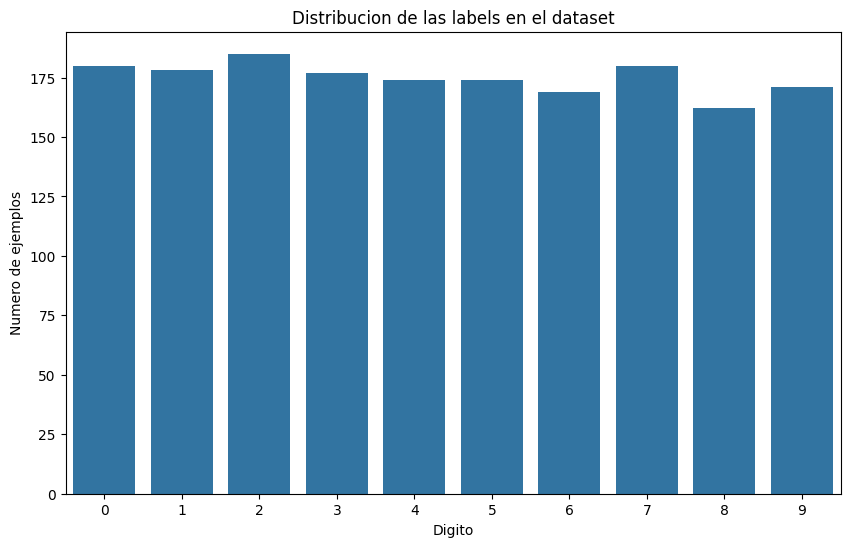

In [17]:
label_counts = {}
for example in train_ds:
  label = example["label"].numpy()
  label_counts[label] = label_counts.get(label, 0) + 1

print("Distribucion de Labels:")
for label, count in sorted(label_counts.items()):
  print(f"Label {label}: {count} ejemplos")

plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title('Distribucion de las labels en el dataset')
plt.xlabel('Digito')
plt.ylabel('Numero de ejemplos')
plt.show()

El dataset muestra una distribución pareja de ejemplos por cada dígito del 0 al 9, con diferencias mínimas entre clases. Todas las categorías tienen una cantidad similar de audios, lo que permite entrenar modelos sin riesgo de sesgo por desbalance. Por eso, se considera que el dataset está balanceado.

### Balanceo por locutor.


Distribucion de Locutores:
Locutor george: 359 ejemplos
Locutor jackson: 351 ejemplos
Locutor nicolas: 338 ejemplos
Locutor theo: 359 ejemplos
Locutor yweweler: 343 ejemplos


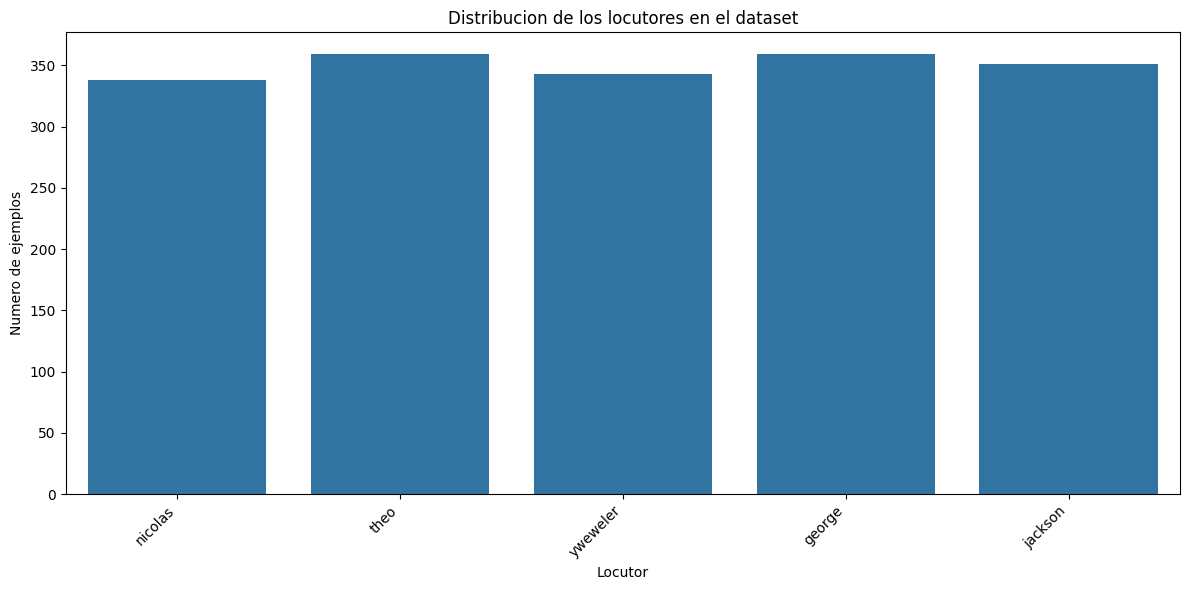

In [18]:
locutor_counts = {}
for example in train_ds:
  filename = example["audio/filename"].numpy()
  locutor = extract_locutor(filename)
  locutor_counts[locutor] = locutor_counts.get(locutor, 0) + 1

print("\nDistribucion de Locutores:")
for locutor, count in sorted(locutor_counts.items()):
  print(f"Locutor {locutor}: {count} ejemplos")

# Plot de distribucion de locutores
plt.figure(figsize=(12, 6))
sns.barplot(x=list(locutor_counts.keys()), y=list(locutor_counts.values()))
plt.title('Distribucion de los locutores en el dataset')
plt.xlabel('Locutor')
plt.ylabel('Numero de ejemplos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Este dataset incluye ejemplos de cinco locutores distintos y la cantidad de audios por persona es muy parecido entre ellos. No se puede observan diferencias claras que puedan generar un sesgo hacia alguna voz en particular. Por esto, se puede considerar que la distribución por locutor también está balanceada.

### Duración de los audios


Promedio de duración de audio: 3276.01 samples
Mediana de duración de audio: 3187.5 samples
Duración mínima de audio: 1288 samples
Duración máxima de audio: 8281 samples


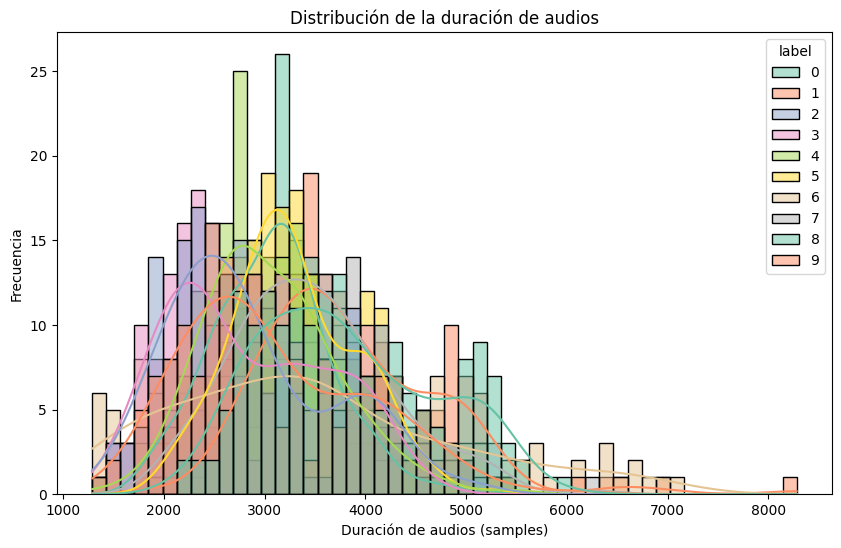

In [19]:
# Listas para almacenar el largo de los audios y los labels.
audio_lengths = []
labels = []

# Almacenado de duraciones de audios y labels.
for example in train_ds:
    audio = example["audio"]
    label = example["label"]
    audio_lengths.append(tf.shape(audio)[0].numpy())
    labels.append(label.numpy())

# Estadísticas de duración de audios
print(f"\nPromedio de duración de audio: {np.mean(audio_lengths):.2f} samples")
print(f"Mediana de duración de audio: {np.median(audio_lengths)} samples")
print(f"Duración mínima de audio: {np.min(audio_lengths)} samples")
print(f"Duración máxima de audio: {np.max(audio_lengths)} samples")

# Df para mostrarlo
df = pd.DataFrame({
    "audio_length": audio_lengths,
    "label": labels
})

plt.figure(figsize=(10, 6))
sns.histplot(df, x="audio_length", hue="label", bins=50, kde=True, palette="Set2")
plt.title('Distribución de la duración de audios')
plt.xlabel('Duración de audios (samples)')
plt.ylabel('Frecuencia')
plt.show()

Las distribuciones de las duraciones de los audios tienen comportamientos similares entre todos los locutores, lo cual quiere decir que no hay discrepancias en tiempo de audio entre las distintas personas.

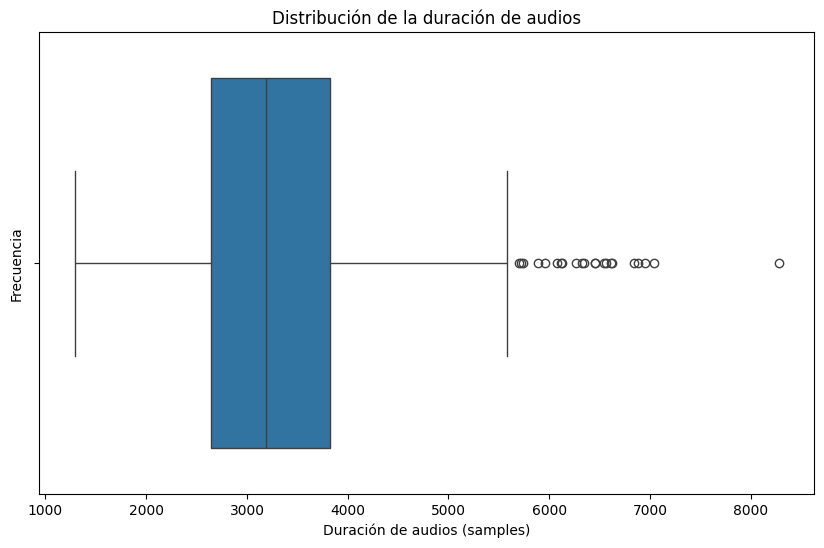

In [20]:
# Boxplot de duraciones de los audios

plt.figure(figsize=(10, 6))
sns.boxplot(df, x="audio_length")

plt.title('Distribución de la duración de audios')
plt.xlabel('Duración de audios (samples)')
plt.ylabel('Frecuencia')
plt.show()

Los gráfico muestran que la duración de los audios está distribuida de forma bastante similar entre las distintas clases, concentrándose mayormente entre los 2000 y 5000 samples. No hay diferencias marcadas entre los dígitos, lo que indica homogeneidad temporal en las muestras, algo positivo para el entrenamiento del modelo. Sin embargo, también se observan algunos audios con duraciones mayores a 5000 o 6000 samples, que son casos poco frecuentes y podrían considerarse outliers.

## Manejo de atípicos.

Observamos si el dataset tiene atípicos en cuanto a la duración de los audios.

Esto se hace principalmente para:
- Detectar si hay audios muy largos que puedan afectar en el entrenamiento del modelo (duración, recursos, etc).
- Detectar si hay audios muy cortos donde lo probable es que no se haya llegado a grabar bien un número o no contenga nada.

In [21]:
# Usamos la regla del IQR.

# Calculamos Q1, Q3 y IQR
Q1 = np.percentile(audio_lengths, 25)
Q3 = np.percentile(audio_lengths, 75)
IQR = Q3 - Q1

# Límites inferior y superior para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = [x for x in audio_lengths if x < lower_bound or x > upper_bound]

In [22]:
print(f"% {(len(outliers_iqr) / len(ds)) * 100}")

% 0.88


Como el porcentaje de outliers no supera el 5% de los datos de entrenamiento, decidimos eliminarlos.

In [23]:
train_ds_sa = train_ds.filter(filter_by_length)

print(f"Cantidad de muestras en Dataset Original: {len(train_ds)}.  \nCantidad de muestras en Dataset filtrado: {sum(1 for _ in train_ds_sa)}.")
filtered_count = sum(1 for _ in train_ds_sa)
print(f"Total de muestras después del filtrado: {filtered_count}")

Cantidad de muestras en Dataset Original: 1750.  
Cantidad de muestras en Dataset filtrado: 1728.
Total de muestras después del filtrado: 1728


## Visualización del dataset en grafico de waveform y Sprectogram

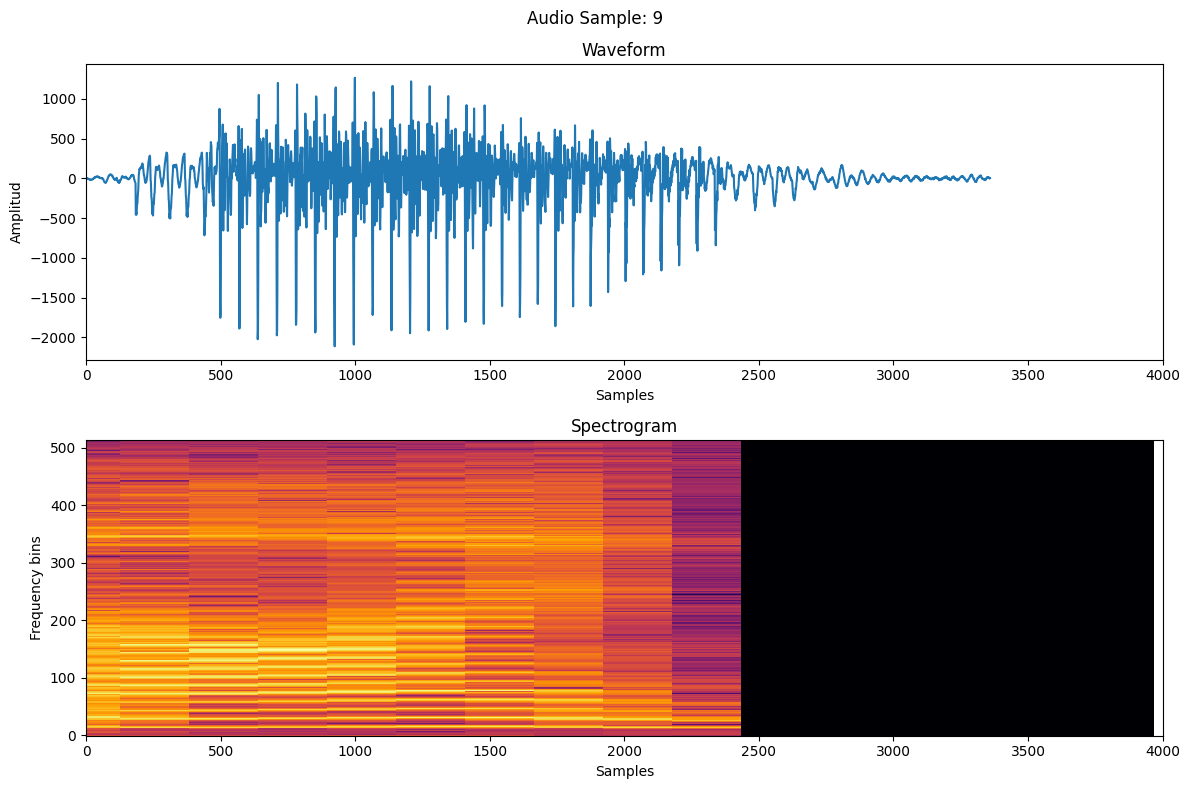

In [24]:
# Obtenemos un ejemplo, su waveform y su label
sample = tfds.as_dataframe(train_ds_sa).iloc[2]
waveform = tf.cast(sample['audio'], tf.float32)
label = sample['label']

# Obtenemos el espectograma
spectrogram = get_spectrogram(waveform)


# Ploteamos waveform y escpectograma
fig, axes = plt.subplots(2, figsize=(12, 8))

timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitud')
axes[0].set_xlim([0, 4000])

plot_spectrogram_padded(spectrogram.numpy(), axes[1], total_samples=4000)
axes[1].set_title('Spectrogram')
plt.suptitle(f"Audio Sample: {label}")
plt.tight_layout()
plt.show()


La visualización muestra la forma de onda, y el espectrograma de una muestra de audio del dígito 9. En la parte superior se puede observa cómo cambia la amplitud del sonido, mientras que en el espectrograma inferior representa las frecuencias presentes y su intensidad.

## Preprocesamiento del dataset

### Armado de datasets de imágenes.

#### Generación de espectogramas y ordenamiendo de archivos en las subcarpetas

In [27]:
spectrogram_directory = "spectrogram_directory"
print(f"Guardando espectrogramas en el directorio: {spectrogram_directory}")

file_names_train_ds_sa = []
file_names_val_ds_sa = []
file_names_test_ds_sa = []

for example in train_ds_sa:
    audio = example["audio"]
    file_name = example["audio/filename"]
    file_names_train_ds_sa.append(file_name)
    save_spectrogram(audio, file_name, f"spectrogram_directory/train")

for example in val_ds:
    audio = example["audio"]
    file_name = example["audio/filename"]
    file_names_val_ds_sa.append(file_name)
    save_spectrogram(audio, file_name, f"spectrogram_directory/val")

for example in test_ds:
    audio = example["audio"]
    file_name = example["audio/filename"]
    file_names_test_ds_sa.append(file_name)
    save_spectrogram(audio, file_name, f"spectrogram_directory/test")


print("Finalizada la generación y guardado de espectrogramas.")

Guardando espectrogramas en el directorio: spectrogram_directory
Espectrograma guardado para 2_nicolas_23.wav en spectrogram_directory/train/2/2_nicolas_23.png
Espectrograma guardado para 1_nicolas_0.wav en spectrogram_directory/train/1/1_nicolas_0.png
Espectrograma guardado para 9_yweweler_4.wav en spectrogram_directory/train/9/9_yweweler_4.png
Espectrograma guardado para 7_nicolas_22.wav en spectrogram_directory/train/7/7_nicolas_22.png
Espectrograma guardado para 5_theo_44.wav en spectrogram_directory/train/5/5_theo_44.png
Espectrograma guardado para 3_george_21.wav en spectrogram_directory/train/3/3_george_21.png
Espectrograma guardado para 6_yweweler_26.wav en spectrogram_directory/train/6/6_yweweler_26.png
Espectrograma guardado para 1_yweweler_37.wav en spectrogram_directory/train/1/1_yweweler_37.png
Espectrograma guardado para 8_theo_39.wav en spectrogram_directory/train/8/8_theo_39.png
Espectrograma guardado para 1_theo_0.wav en spectrogram_directory/train/1/1_theo_0.png
Espec

In [28]:
# Obtenemos los files_paths ordenados de test.
# Esto se hace para luego poder obtener el audio correspondiente
# a un espectograma en test_ds_espect desde el test_ds por índice.

files_test = get_ordered_file_paths("spectrogram_directory/test")

### Carga de datasets en formato tf.image_dataset

Se cargan los datasets de train, validación y test. Tanto train como validación tienen shuffle = True ya que un train sin shuffle afrectaría en el aprendizaje del modelo.

Por otro lado, se escoge poner en test un shuffle = False para luego poder haacer la búsqueda por índice del audio correspondiente a un espectograma en el dataset de audios.

In [29]:
train_ds_espect = tf.keras.utils.image_dataset_from_directory(
    "spectrogram_directory/train", image_size=(128, 128), batch_size=32)

val_ds_espect = tf.keras.utils.image_dataset_from_directory(
    "spectrogram_directory/val", image_size=(128, 128), batch_size=32)

test_ds_espect = tf.keras.utils.image_dataset_from_directory(
    "spectrogram_directory/test", image_size=(128, 128), batch_size=32,shuffle = False)

Found 1728 files belonging to 10 classes.
Found 375 files belonging to 10 classes.
Found 375 files belonging to 10 classes.


### Visualización del dataset train

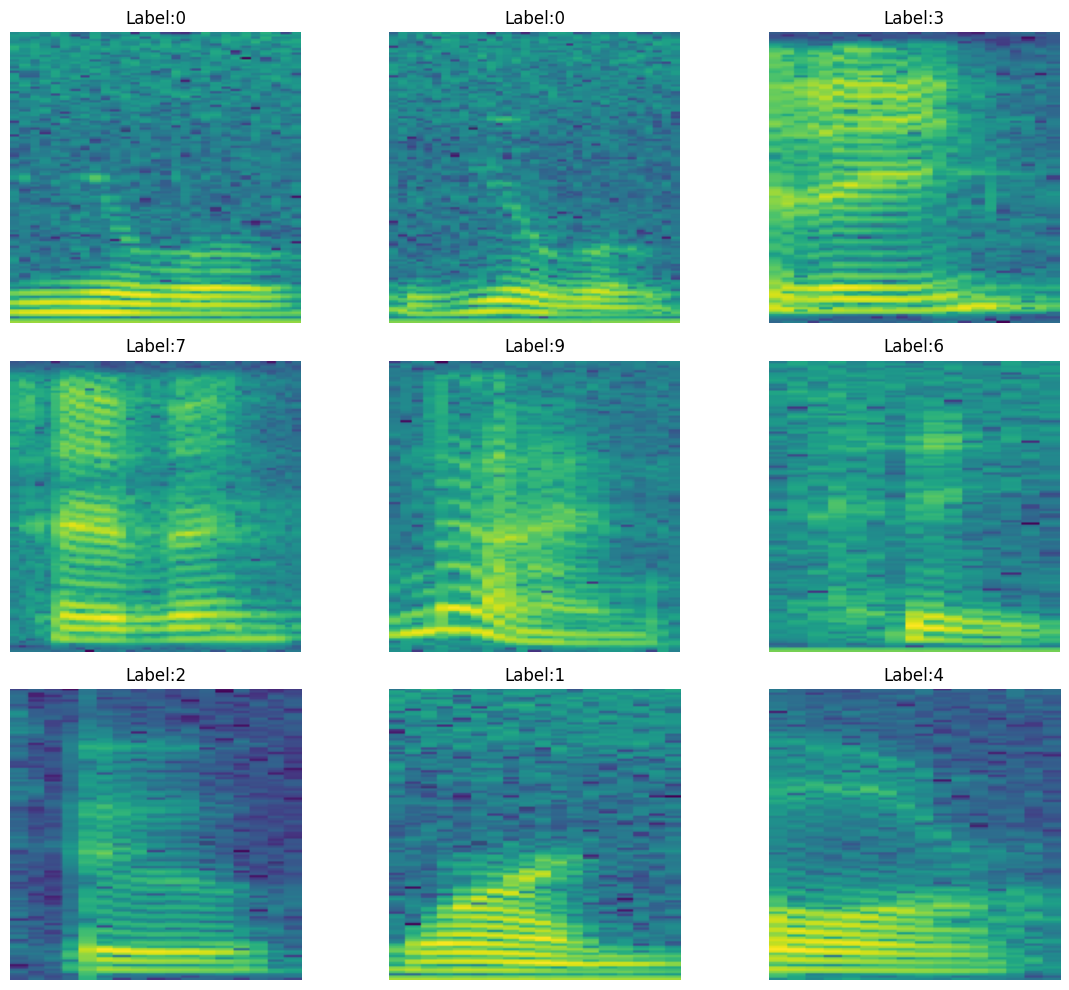

In [30]:
# Mostrar los primeros 9 espectrogramas del primer batch del train
for images, labels in train_ds_espect.take(1):
    num_images = min(9, len(images))

    fig, axes = plt.subplots(3, 3, figsize=(12, 10))  # 3 filas x 3 columnas

    for i in range(num_images):
        row = i // 3
        col = i % 3
        ax = axes[row, col]

        img = images[i].numpy()
        if img.max() > 1:
            img = img / 255.0  # normalizar si es necesario

        ax.imshow(img)
        ax.set_title(f"Label:{labels[i]}")
        ax.axis('off')

    # Ocultar subplots vacíos si hay menos de 9 imágenes
    for j in range(num_images, 9):
        row = j // 3
        col = j % 3
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


## Modelo convolucional para espectrogramas

Armado de modelo convolucional, entrenamiento y evaluación del mismo. Conclusiones sobre dicho modelo.

### Armado del modelo

Se decide que el modelo tenga esta estructura ya que, dada la cantidad de datos y la diferenciación visualizada entre los espectogramas de un número y otros, se necesita un modelo que no sea muy grande para que no sufra overfitting. (Hay 1728 datos en train, lo cual no es mucho)

In [31]:
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del modelo

In [32]:
# Entrenamiento con validación
history = model.fit(
    train_ds_espect,
    validation_data=val_ds_espect,
    epochs=25
)
# Evaluación en el set de test
test_loss, test_acc = model.evaluate(test_ds_espect)
print(f"Accuracy en test: {test_acc:.2f}")


Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - accuracy: 0.1055 - loss: 56.7552 - val_accuracy: 0.0960 - val_loss: 2.1788
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.1473 - loss: 2.1942 - val_accuracy: 0.2000 - val_loss: 2.1228
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.1673 - loss: 2.1575 - val_accuracy: 0.2000 - val_loss: 2.0892
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.1565 - loss: 2.1134 - val_accuracy: 0.2773 - val_loss: 1.8423
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.2726 - loss: 1.8665 - val_accuracy: 0.5627 - val_loss: 1.4257
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.4366 - loss: 1.5130 - val_accuracy: 0.6533 - val_loss: 1.0707
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.5540 - loss: 1.3136 - val_accuracy: 0.7387 - val_loss: 0.8728
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.5823 - loss: 1.1520 - val_accura

### Evaluación del modelo

#### Metricas de entrenamiento en train y val

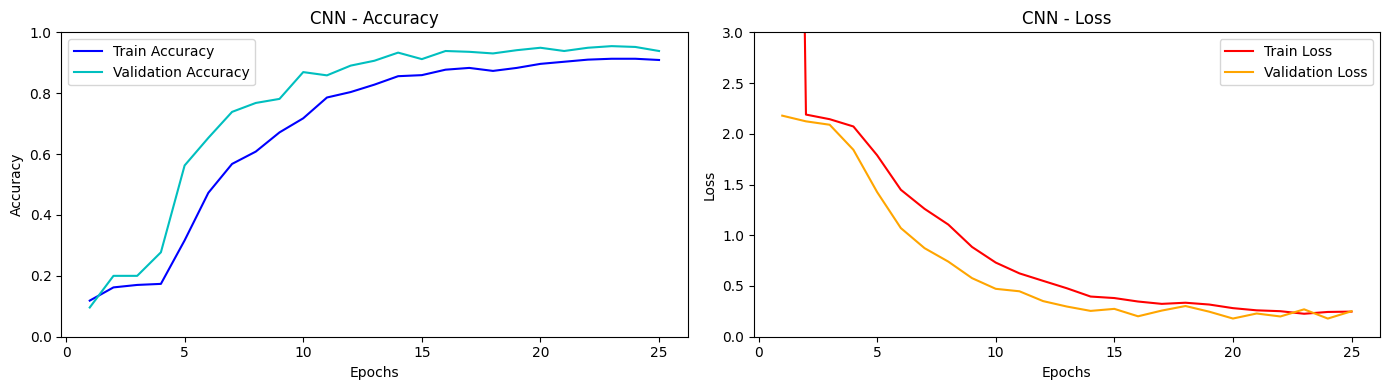

In [48]:
# Métricas de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'c-', label='Validation Accuracy')
plt.title('CNN - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Train Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('CNN - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 3)
plt.legend()

plt.tight_layout()
plt.show()

Podemos observar que el modelo estabiliza su accuracy en las 9 épocas, siendo cuando val y train están mas cerca en la época 11 y 14. Podemos ver que este modelo tiene un pequeño sobreajuste ya que tiene un valor similar para ambos.

#### Matriz de confusión

Visualizamos la matriz de confusión ya que es un gráfico que permite ver con claridad en qué clases el modelo se está equivocando, por cuál se equivoca y también si tiene un sesgo hacia alguna clase.

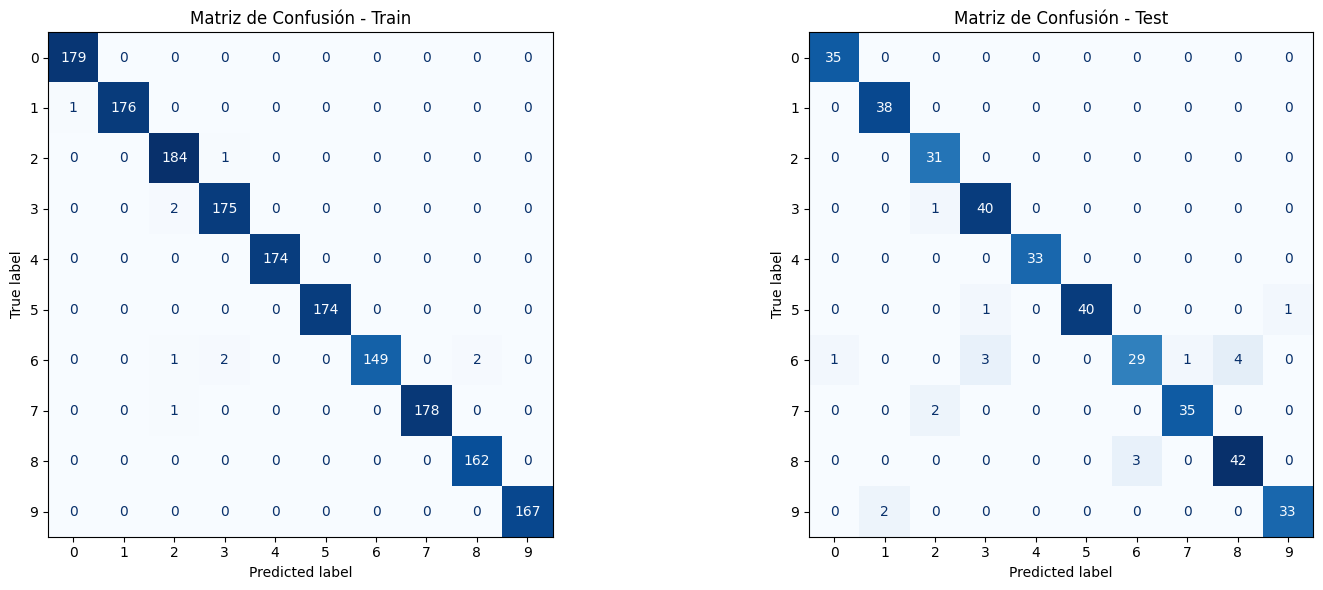

In [49]:
# Obtener predicciones y valores reales
y_true = []
y_pred = []
y_true_train = []
y_pred_train = []


for images, labels in test_ds_espect:
    preds_test = model(images, training=False)
    y_pred.extend(np.argmax(preds_test, axis=1))
    y_true.extend(labels.numpy())
cm_test = confusion_matrix(y_true, y_pred)

for images, labels in train_ds_espect:
    preds_train = model(images, training=False)
    y_pred_train.extend(np.argmax(preds_train, axis=1))
    y_true_train.extend(labels.numpy())
cm_train = confusion_matrix(y_true_train, y_pred_train)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=list(range(10)))
disp_train.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Matriz de Confusión - Train")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=list(range(10)))
disp_test.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Matriz de Confusión - Test")

plt.tight_layout()
plt.show()


Podemos observar que el modelo tiene muy bajas equivocaciones, la clase que más equivocaciones tiene es la 6, que confunde en train 2 muestras con el número 8 y en validación se emparejan más las equivocaciones, pero en ningún caso se superan las 2 equivocaciones para una clase, es decir, el 1%

#### Primeras 10 predicciones con su audio, label predicho  y label real


In [35]:
# test_ds: dataset original (audio, label, audio/filename)
audio_map = {}

for example in test_ds:
    fname = example["audio/filename"].numpy().decode("utf-8")
    audio_map[fname] = (example["audio"].numpy(), example["label"].numpy())


In [36]:
spectrogram_batch, _ = next(iter(test_ds_espect.take(100)))   # imágenes
num_examples = min(9, spectrogram_batch.shape[0])

In [37]:
spectrograms = []
labels = []

for batch_images, batch_labels in test_ds_espect:
    spectrograms.append(batch_images)
    labels.append(batch_labels)

spectrograms = tf.concat(spectrograms, axis=0)
labels = tf.concat(labels, axis=0)

preds = model.predict(spectrograms)

num_examples = 9  # cantidad de ejemplos a mostrar
indices = np.random.choice(len(spectrograms), num_examples, replace=False)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [38]:
html = "<table style='width:100%; text-align:center'>"

for i, idx in enumerate(indices):
    if i % 3 == 0:
        html += "<tr>"

    # Nombre archivo
    png_path = files_test[idx]
    wav_name = png_path.name.replace(".png", ".wav")

    # Audio y label real
    audio_np, real_label = audio_map[wav_name]

    # Predicción
    pred_probs = preds[idx]
    pred_label = np.argmax(pred_probs)
    confidence = pred_probs[pred_label]

    # Audio HTML
    audio_html = ipd.Audio(audio_np, rate=8000)._repr_html_()
    label_html = (f"<p>Real: {real_label}<br>Pred: {pred_label} ({confidence:.2f})</p>")

    html += f"<td>{audio_html}{label_html}</td>"

    if i % 3 == 2 or i == num_examples - 1:
        html += "</tr>"

html += "</table>"
display(HTML(html))


###Conclusión del modelo.

Pudimos observar como el modelo convolucional funcionó bastante bien para clasificar los dígitos a partir de los espectrogramas. Aprovechando la información del espectrograma y aprendiendo patrones útiles. Tuvo muy buen rendimiento tanto en train,como en validación y test.

## Modelo recurrente

Armamos un modelo recurrente con capa LSTM.  La elección de esta arquitectura se fundamenta en las características temporales propias de los datos sonoros y la representación elegida: los espectrogramas. De esta manera, se encontraría una relación en el orden en el que se dicen unas letras para formar una palabra, la duración en la pronunciación de cada letra y demás.

### Armado del modelo.

In [39]:
img_height = 32
img_width = 32

input_shape = (img_height, img_width) # secuencia de 32 pasos, vector de 32 features por paso
model_recurrente = tf.keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])


# Compilación con tasa de aprendizaje personalizada
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_recurrente.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

model_recurrente.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 32, 128)        │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,386 (614.79 KB)

 Trainable params: 157,386 (614.79 KB)

 Non-trainable params: 0 (0.00 B)

#### Preprocesamiento de dataset para adecuarlo a RNN LSTM.

Se convierte las imágenes a gris, se le hace un resize de 64x64 para un mejor funcionamiento del modelo y se las aplana para que funcionen con la RNN.

In [40]:
# Entrenamiento
train_ds_espect_gray = train_ds_espect.unbatch()
train_ds_espect_gray = train_ds_espect_gray.map(
    lambda x, y: preprocess(x, y, img_height=img_height, img_width=img_width)
)
train_ds_espect_gray = train_ds_espect_gray.batch(32).prefetch(tf.data.AUTOTUNE)

# Validación
val_ds_espect_gray = val_ds_espect.unbatch()
val_ds_espect_gray = val_ds_espect_gray.map(
    lambda x, y: preprocess(x, y, img_height=img_height, img_width=img_width)
)
val_ds_espect_gray = val_ds_espect_gray.batch(32).prefetch(tf.data.AUTOTUNE)

# Test
test_ds_espect_gray = test_ds_espect.unbatch()
test_ds_espect_gray = test_ds_espect_gray.map(
    lambda x, y: preprocess(x, y, img_height=img_height, img_width=img_width)
)
test_ds_espect_gray = test_ds_espect_gray.batch(32).prefetch(tf.data.AUTOTUNE)


Visualizamos que se haya procesado correcatmente el dataset.

In [41]:
for x, y in train_ds_espect_gray.take(1):
    print(x.shape, y)


(32, 32, 32) tf.Tensor([1 6 0 8 3 3 2 8 1 5 7 6 1 7 3 0 5 1 0 9 2 9 7 6 7 7 3 3 3 5 5 9], shape=(32,), dtype=int32)


### Entrenamiento del modelo.

In [42]:
epochs=50
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_recurrete = model_recurrente.fit(
    train_ds_espect_gray,
    validation_data=val_ds_espect_gray,
    epochs=epochs,
    callbacks=[early_stop])

Epoch 1/50
     54/Unknown 12s 126ms/step - accuracy: 0.1162 - loss: 2.3109

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.1167 - loss: 2.3105 - val_accuracy: 0.2480 - val_loss: 2.1848
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.2554 - loss: 2.0813 - val_accuracy: 0.5067 - val_loss: 1.6324
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.4772 - loss: 1.4749 - val_accuracy: 0.5920 - val_loss: 1.1854
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.6149 - loss: 1.0816 - val_accuracy: 0.7067 - val_loss: 0.8358
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.7422 - loss: 0.7468 - val_accuracy: 0.7840 - val_loss: 0.6462
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7953 - loss: 0.5855 - val_accuracy: 0.7787 - val_loss: 0.6017
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.8427 - loss: 0.4553 - val_accuracy: 0.8240 - val_loss: 0.5337
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.8446 - loss: 0.4160 - val_accuracy: 0.8080 -

### Evaluación del modelo

#### Metricas de accuracy y loss en train y val.

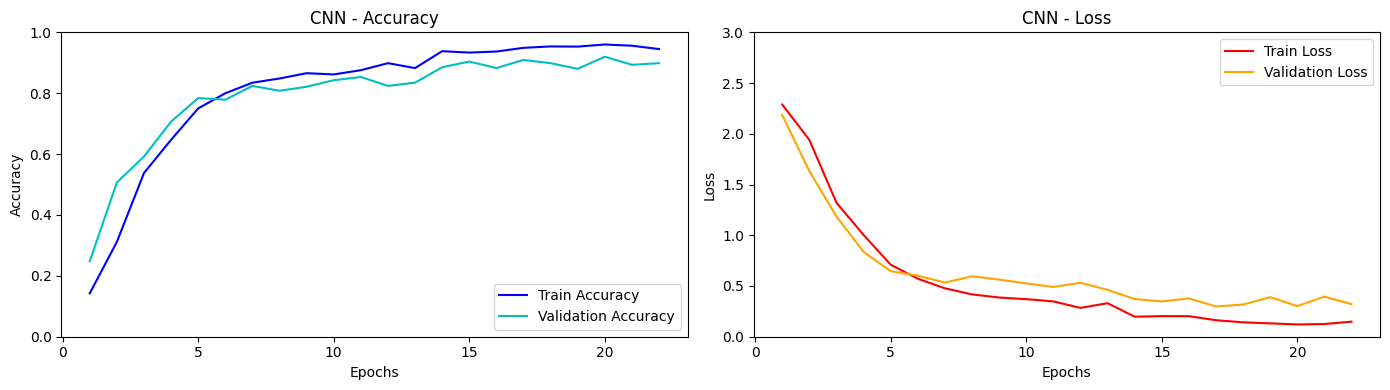

In [43]:
# Métricas de entrenamiento
acc_r = history_recurrete.history['accuracy']
val_acc_r = history_recurrete.history['val_accuracy']
loss_r = history_recurrete.history['loss']
val_loss_r = history_recurrete.history['val_loss']
epochs_r = range(1, len(acc_r) + 1)

# Accuracy
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_r, acc_r, 'b-', label='Train Accuracy')
plt.plot(epochs_r, val_acc_r, 'c-', label='Validation Accuracy')
plt.title('RNN - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_r, loss_r, 'r-', label='Train Loss')
plt.plot(epochs_r, val_loss_r, 'orange', label='Validation Loss')
plt.title('RNN - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 3)
plt.legend()

plt.tight_layout()
plt.show()

Podemos observar que en el modelo, el conjunto de Train se estabiliza cerca de las 10 epocas, con pequeñas variaciones despues de ella. Pasa algo similar con el conjunto de validacion.
Luego, podemos observar que la perdida disminuye constantemente, lo que indica que la red esta ajustando bien los pesos

In [50]:
test_acc_r = model_recurrente.evaluate(test_ds_espect_gray)[1]
print(f"Accuracy en test: {test_acc:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9276 - loss: 0.2267
Accuracy en test: 0.95


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


#### Matriz de confusión del modelo.

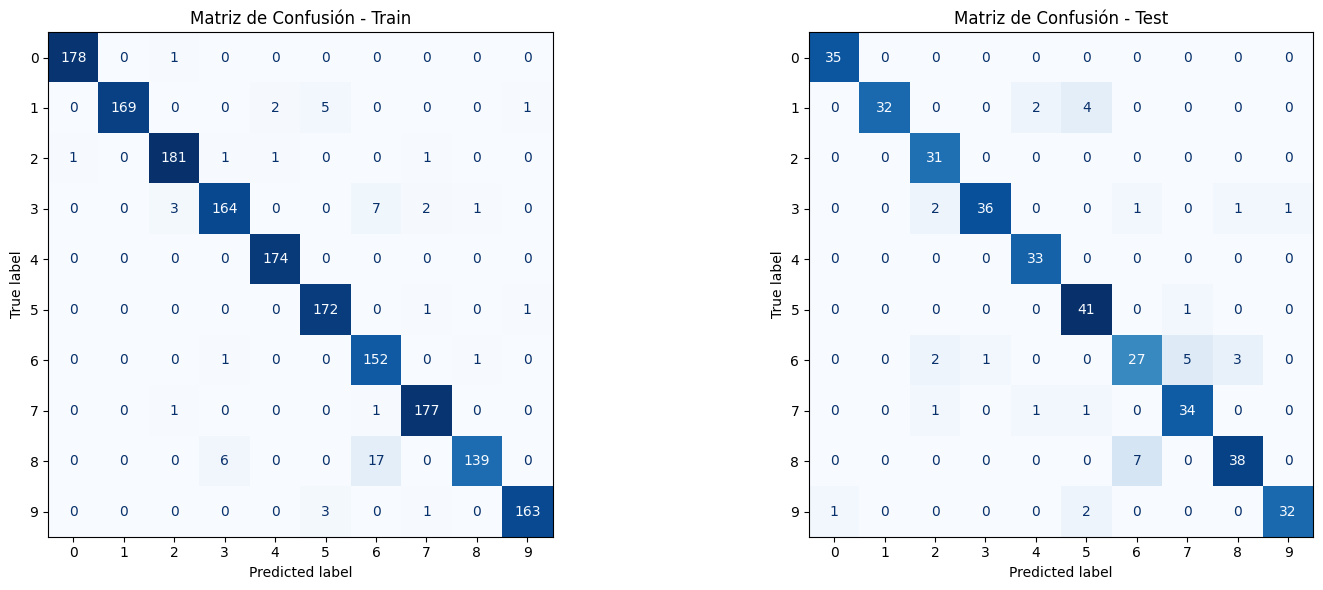

In [45]:
# Obtener predicciones reales
y_true_r = []
y_pred_r = []
y_true_r_train = []
y_pred_r_train = []

for images, labels in test_ds_espect_gray:
    preds_test_r = model_recurrente(images, training=False)
    y_pred_r.extend(np.argmax(preds_test_r, axis=1))
    y_true_r.extend(labels.numpy())
cm_test_r = confusion_matrix(y_true_r, y_pred_r)

for images, labels in train_ds_espect_gray:
    preds_train_r = model_recurrente(images, training=False)
    y_pred_r_train.extend(np.argmax(preds_train_r, axis=1))
    y_true_r_train.extend(labels.numpy())
cm_train_r = confusion_matrix(y_true_r_train, y_pred_r_train)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train_r, display_labels=list(range(10)))
disp_train.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Matriz de Confusión - Train")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test_r, display_labels=list(range(10)))
disp_test.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Matriz de Confusión - Test")

plt.tight_layout()
plt.show()

Observamos que este modelo tiene bajos errores en la clasificación de los espectogramas en números. En el número que más se equivoca es en el 5, observando en train 9 equivocaciones, lo que corresponde al 5% de los datos aprox.

#### Primeras 10 predicciones con su audio, label predicho  y label real


In [46]:
spectrograms_r = []
labels_r = []

for batch_images, batch_labels in test_ds_espect_gray:
    spectrograms_r.append(batch_images)
    labels_r.append(batch_labels)

spectrograms_r = tf.concat(spectrograms_r, axis=0)
labels_r = tf.concat(labels_r, axis=0)

preds_r = model_recurrente.predict(spectrograms_r)

num_examples = 9  # cantidad de ejemplos a mostrar
indices_r = np.random.choice(len(spectrograms_r), num_examples, replace=False)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [47]:
html = "<table style='width:100%; text-align:center'>"

for i, idx in enumerate(indices_r):
    if i % 3 == 0:
        html += "<tr>"

    # Nombre archivo
    png_path = files_test[idx]
    wav_name = png_path.name.replace(".png", ".wav")

    # Audio y label real
    audio_np, real_label = audio_map[wav_name]

    # Predicción
    pred_probs_r = preds_r[idx]
    pred_label_r = np.argmax(pred_probs_r)
    confidence_r = pred_probs_r[pred_label_r]

    # Audio HTML
    audio_html = ipd.Audio(audio_np, rate=8000)._repr_html_()
    label_html = (f"<p>Real: {real_label}<br>Pred: {pred_label_r} ({confidence_r:.2f})</p>")

    html += f"<td>{audio_html}{label_html}</td>"

    if i % 3 == 2 or i == num_examples - 1:
        html += "</tr>"

html += "</table>"
display(HTML(html))


### Conclusión del modelo.

A partir de lo visto anteriormente podemos decir que el modelo recurrente funciono bastante bien para poder clasificar los digitos a partir de espectogramas aprovechando toda la información dada


## Conclusiones generales.

Gracias a todo lo visto anteriormente, podemos decir que funciono mejor el modelo convolucional, ya que aunque en los graficos de metricas de el modelo recurrente se pueda ver una estabilizacion mas rapida de los conjuntos train y val, el **modelo convolucional** tiene menor cantidad de errores que el **modelo recurrente**.

Tambien se puede observar cuando se hacen las primeras 10 predicciones, que en el modelo convolucional, el valor predicho tiene mas confianza que en el modelo recurrente.

Entonces a partir de toda esta informacion, podemos decir que el **modelo recurrente** es el **mejor** para esta aplicacion.